# BPASS Comparison - NGC 337
---

Compare the results of fitting NGC 337 with the PEGASE and BPASS stellar population models.

## Imports

In [21]:
import numpy as np
import h5py
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## Setup

In [22]:
cat = Table.read('../photometry/ngc337_dale17_photometry.fits')

# Some annoyance with converting table columns to flat numpy arrays and text encoding:
# strings come in as bytestrings (unencoded) by default python wants UTF-8, I think.
# The labels are also padded with spaces.
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

print('PEGASE setup:')
lgh_pg = Lightning(filter_labels, 
                   lum_dist=dl, 
                   stellar_type='PEGASE',
                   SFH_type='Piecewise-Constant',
                   atten_type='Modified-Calzetti',
                   dust_emission=True,
                   model_unc=0.10,
                   print_setup_time=True)

print('BPASS setup:')
lgh_bp = Lightning(filter_labels, 
                   lum_dist=dl, 
                   stellar_type='BPASS',
                   SFH_type='Piecewise-Constant',
                   atten_type='Modified-Calzetti',
                   dust_emission=True,
                   model_unc=0.10,
                   print_setup_time=True)

lgh_pg.flux_obs = fnu_obs * 1e3
lgh_pg.flux_unc = fnu_unc * 1e3

lgh_bp.flux_obs = fnu_obs * 1e3
lgh_bp.flux_unc = fnu_unc * 1e3

lgh_pg.save_json('ngc337_config.json')
lgh_bp.save_json('ngc337_config_BPASS.json')

PEGASE setup:
0.179 s elapsed in _get_filters
0.003 s elapsed in _get_wave_obs
0.244 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.336 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
1.762 s elapsed total
BPASS setup:
0.010 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.364 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.097 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
0.472 s elapsed total


On average the BPASS model setup seems to take a little longer, likely due to file IO since the BPASS model files are larger on disk. They're gridded at 5 Angstrom resolution; this will probably change in the future, since it makes every model file ~50 MB.

Notice that the BPASS models have one extra parameter, $\log U$:

In [3]:
print('With PEGASE models:')
lgh_pg.print_params(verbose=True)
print()
print('With BPASS models:')
lgh_bp.print_params(verbose=True)

With PEGASE models:

Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Modified-Calzetti
      Parameter   Lo  Hi                                              Description
--------------- ---- --- --------------------------------------------------------
mcalz_tauV_diff  0.0 inf                         Optical depth of the diffuse ISM
    mcalz_delta -inf inf      Deviation from the Calzetti+2000 UV power law slope
  mcalz_tauV_BC  0.0 inf Optical depth of the birth cloud in star forming regions

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_a

## Fit Both Models With BFGS
And briefly explore the parameter space around the solution to derive uncertainties.

In [23]:
p0_pg = np.array([5,5,0,0,0,
               0.1, -1.0, 0.0,
               2, 3, 3e5, 0.01, 0.02])

p0_bp = np.array([5,5,0,0,0,
                  -2.0,
                  0.1, -1.0, 0.0,
                  2, 3, 3e5, 0.01, 0.02])

bounds_pg = [(0,10), (0,10), (0,10), (0,10), (0,10),
             (0,3),(-3,3),(0,0),
             (2,2), (0.1,25), (3e5,3e5), None, None]

bounds_bp = [(0,10), (0,10), (0,10), (0,10), (0,10),
             (-2,-2), # logU is fixed -- no line flux data to constrain it (yet?)
             (0,3),(-3,3),(0,0),
             (2,2), (0.1,25), (3e5,3e5), None, None]

print('PEGASE Model:')
res_pg,mcmc_pg = lgh_pg.fit(p0_pg,
                            method='optimize',
                            bounds=bounds_pg,
                            MCMC_followup=True,
                            MCMC_kwargs={'Nwalkers':128,'Nsteps':1000, 'init_scale':1e-3, 'progress':True},
                            disp=False)
# We get a scipy.optimize.OptimizeResult object and an emcee.EnsembleSampler object back
print(res_pg)

print('BPASS Model:')
res_bp,mcmc_bp = lgh_bp.fit(p0_bp,
                            method='optimize',
                            bounds=bounds_bp,
                            MCMC_followup=True,
                            MCMC_kwargs={'Nwalkers':128,'Nsteps':1000, 'init_scale':1e-3, 'progress':True},
                            disp=False)
print(res_bp)

PEGASE Model:


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.96it/s]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8.091670997685032
        x: [ 6.337e-01  3.656e+00 ...  1.325e-02  2.412e-02]
      nit: 122
      jac: [ 3.267e-04 -1.763e-03 ... -9.455e-02 -1.711e-01]
     nfev: 1881
     njev: 171
 hess_inv: None
BPASS Model:


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.59it/s]

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 16.769645520095146
        x: [ 1.631e-01  7.069e+00 ...  1.349e-02  2.448e-02]
      nit: 303
      jac: [-5.330e-03 -5.734e-04 ...  1.218e-02  3.297e-04]
     nfev: 4323
     njev: 393
 hess_inv: None


In [24]:
const_dim_pg = np.array([(b is not None) and (b[1] - b[0] == 0) for b in bounds_pg])
chain_pg, logprob_chain_pg, tau_ac_pg = lgh_pg.get_mcmc_chains(mcmc_pg, discard=0, thin=30,
                                                               const_dim=const_dim_pg,
                                                               Nsamples=1000,
                                                               const_vals=res_pg.x[const_dim_pg])

const_dim_bp = np.array([(b is not None) and (b[1] - b[0] == 0) for b in bounds_bp])
chain_bp, logprob_chain_bp, tau_ac_bp= lgh_bp.get_mcmc_chains(mcmc_bp, discard=0, thin=30,
                                                              const_dim=const_dim_bp,
                                                              Nsamples=1000,
                                                              const_vals=res_bp.x[const_dim_bp])

         The autocorrelation estimate may be unreliable.
         The autocorrelation estimate may be unreliable.


The warning about the autocorrelation time isn't surprising; we ran a very short chain for the followup. Figuring out the correct setup for the parameter space exploration after the fact will probably take tuning; this would be an ideal case for automatic termination, cutting it off once we've drawn 50 or so estimated samples (if all we need is uncertainty around the minimum). For now I've been taking the short-chain-many-walkers shotgun approach.

## Diagnostic Plots

Text(0.5, 1.0, 'BPASS')

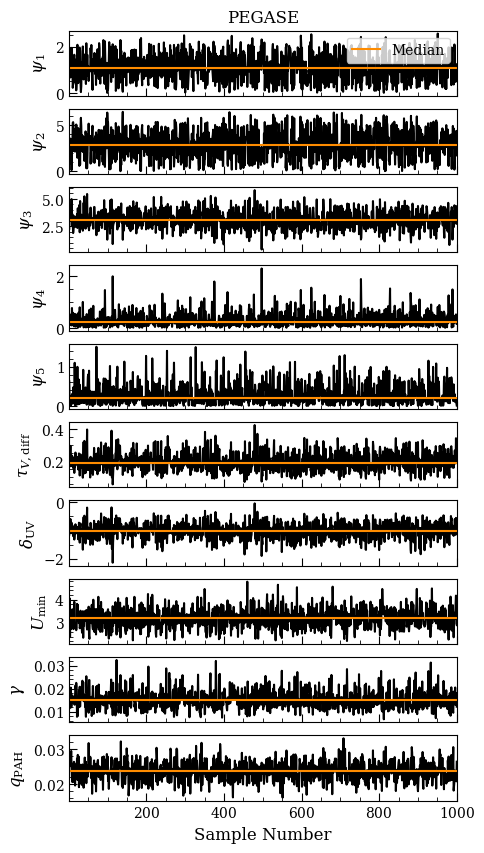

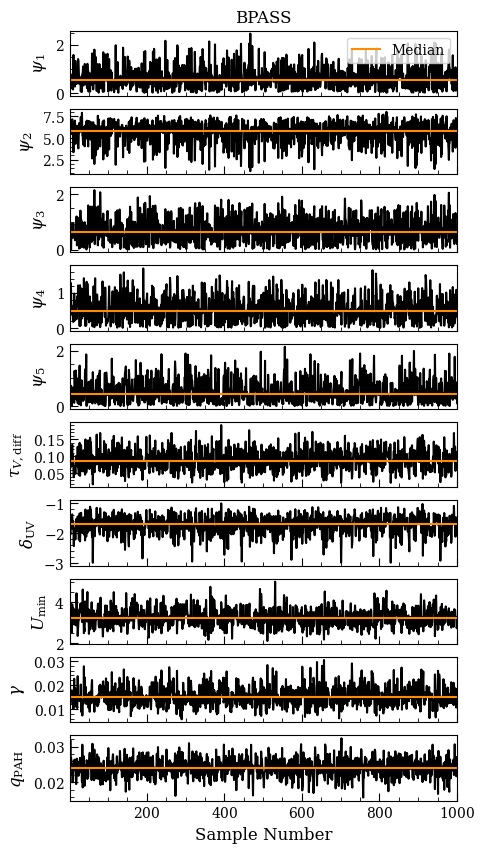

In [6]:
fig_pg, axs_pg = lgh_pg.chain_plot(chain_pg)
fig_bp, axs_bp = lgh_bp.chain_plot(chain_bp)

axs_pg[0].set_title('PEGASE')
axs_bp[0].set_title('BPASS')

Text(0.5, 0.95, 'BPASS')

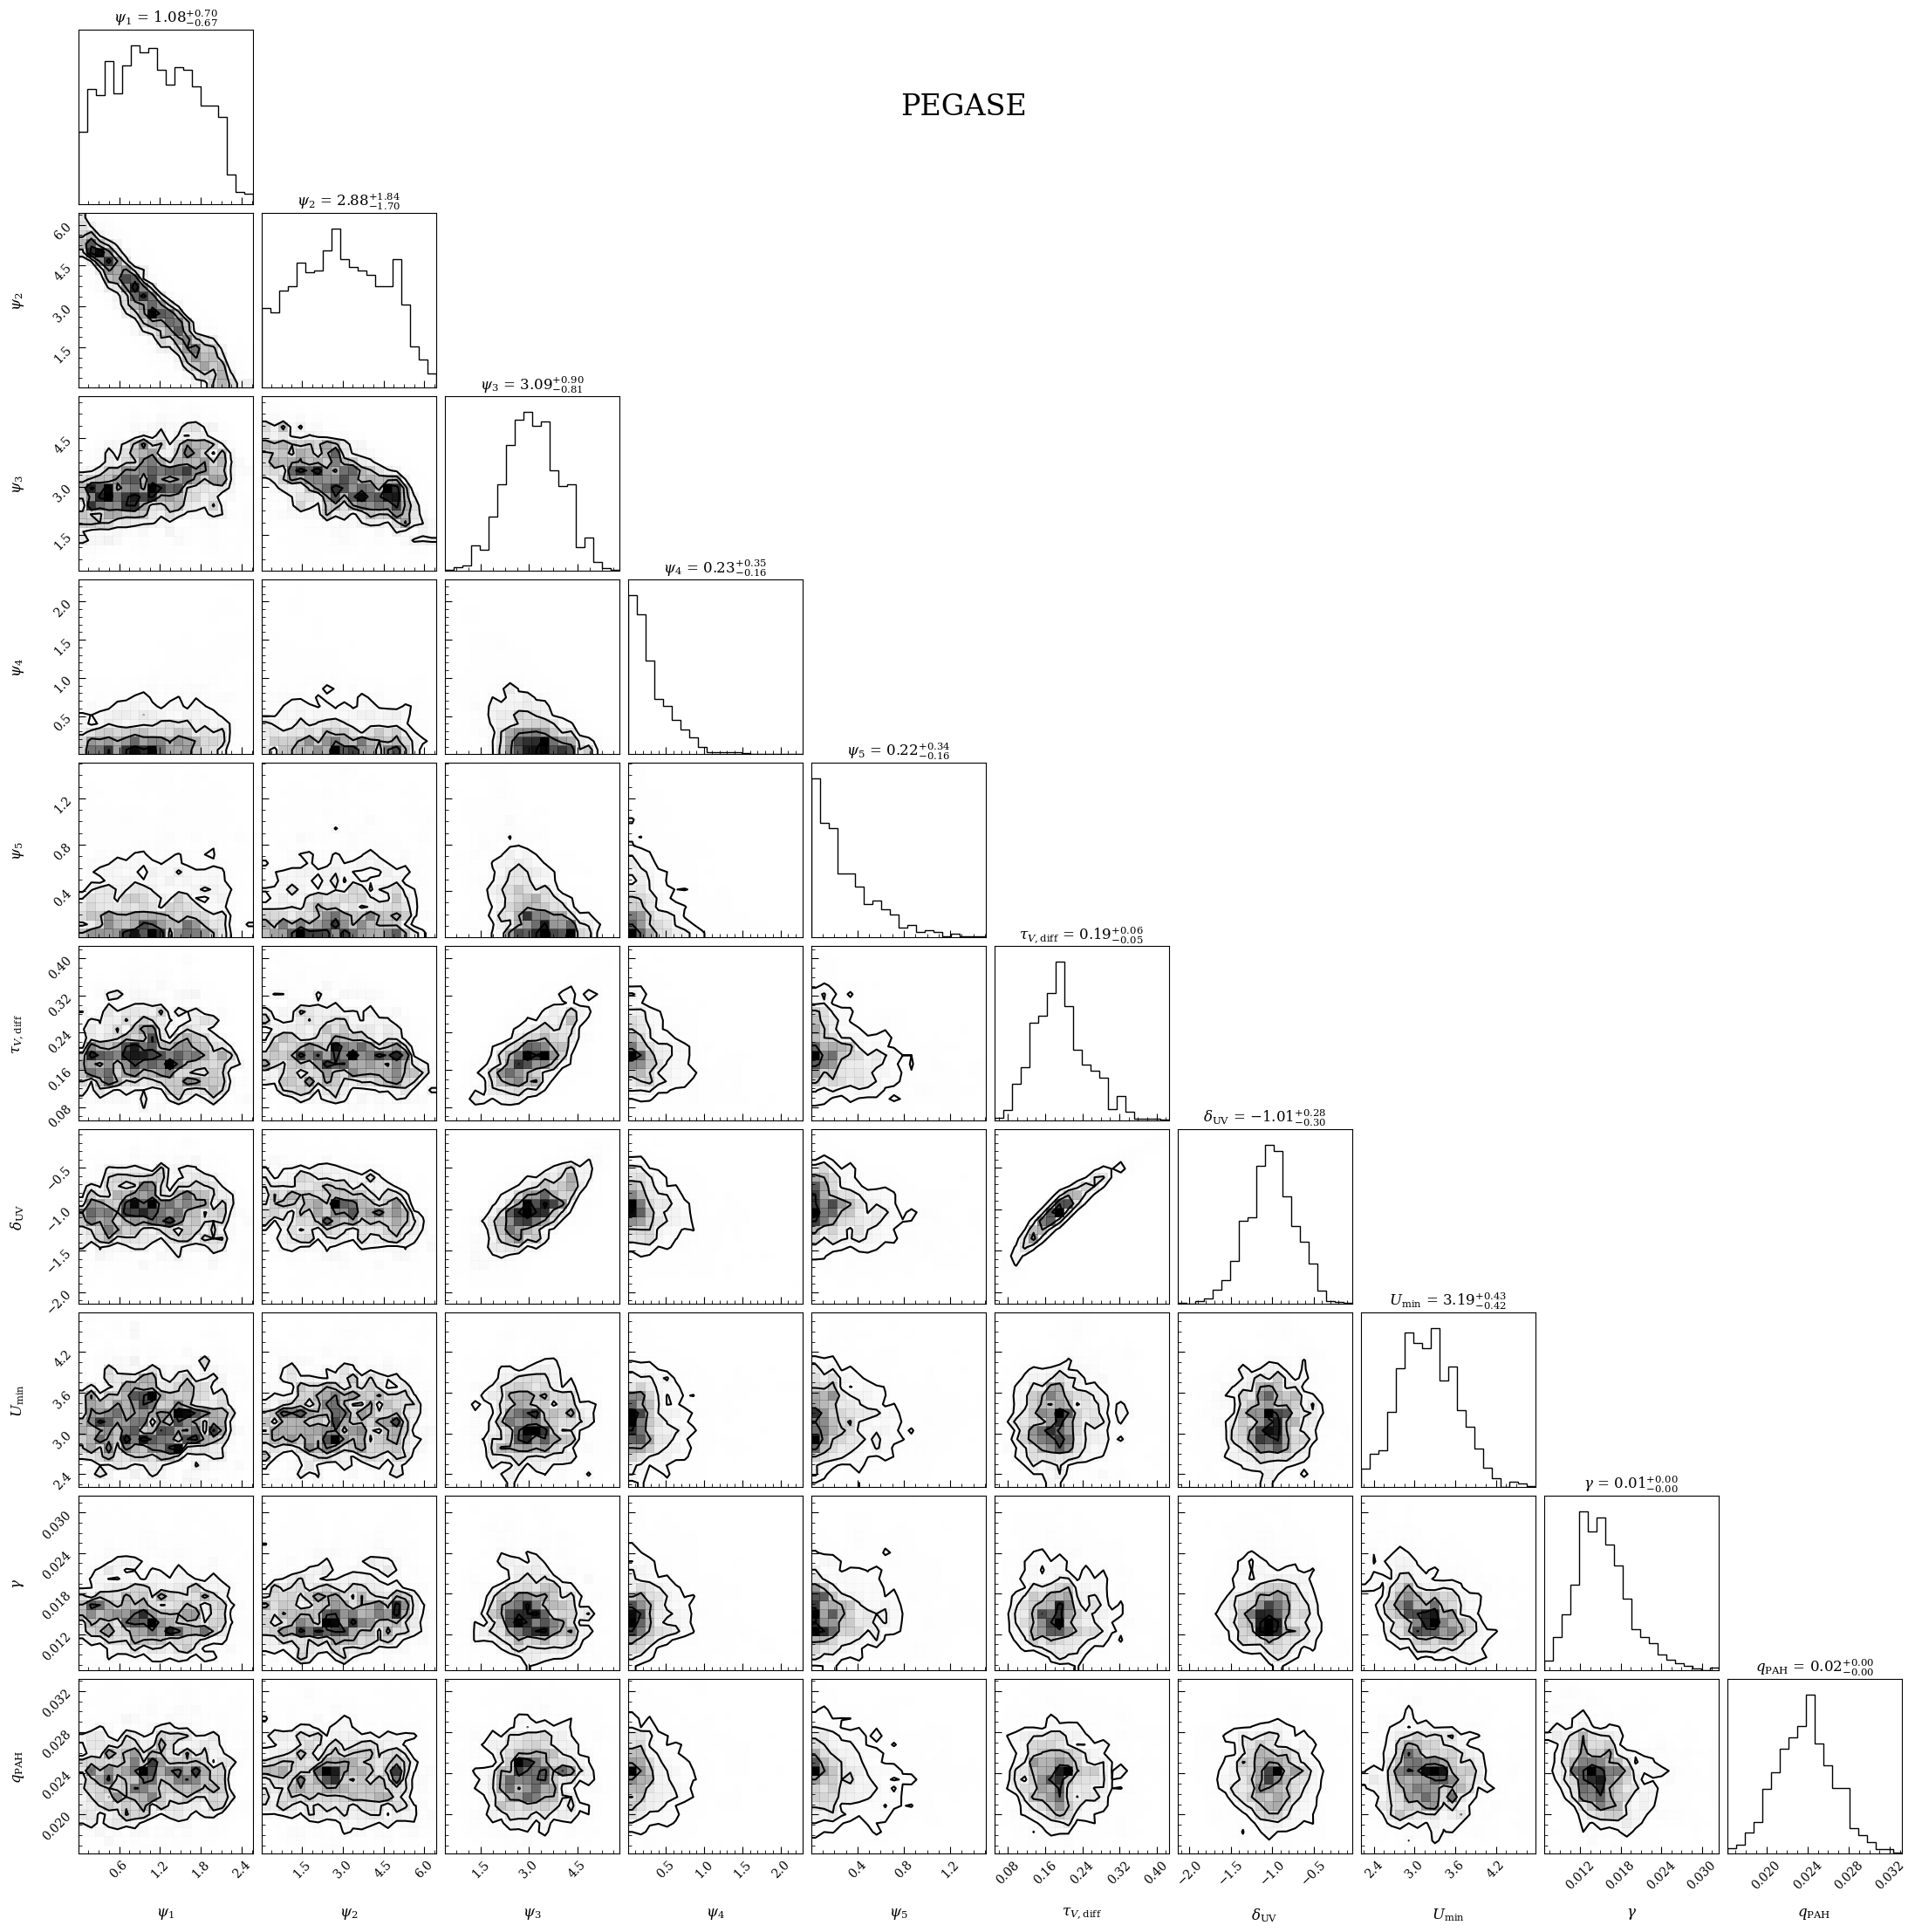

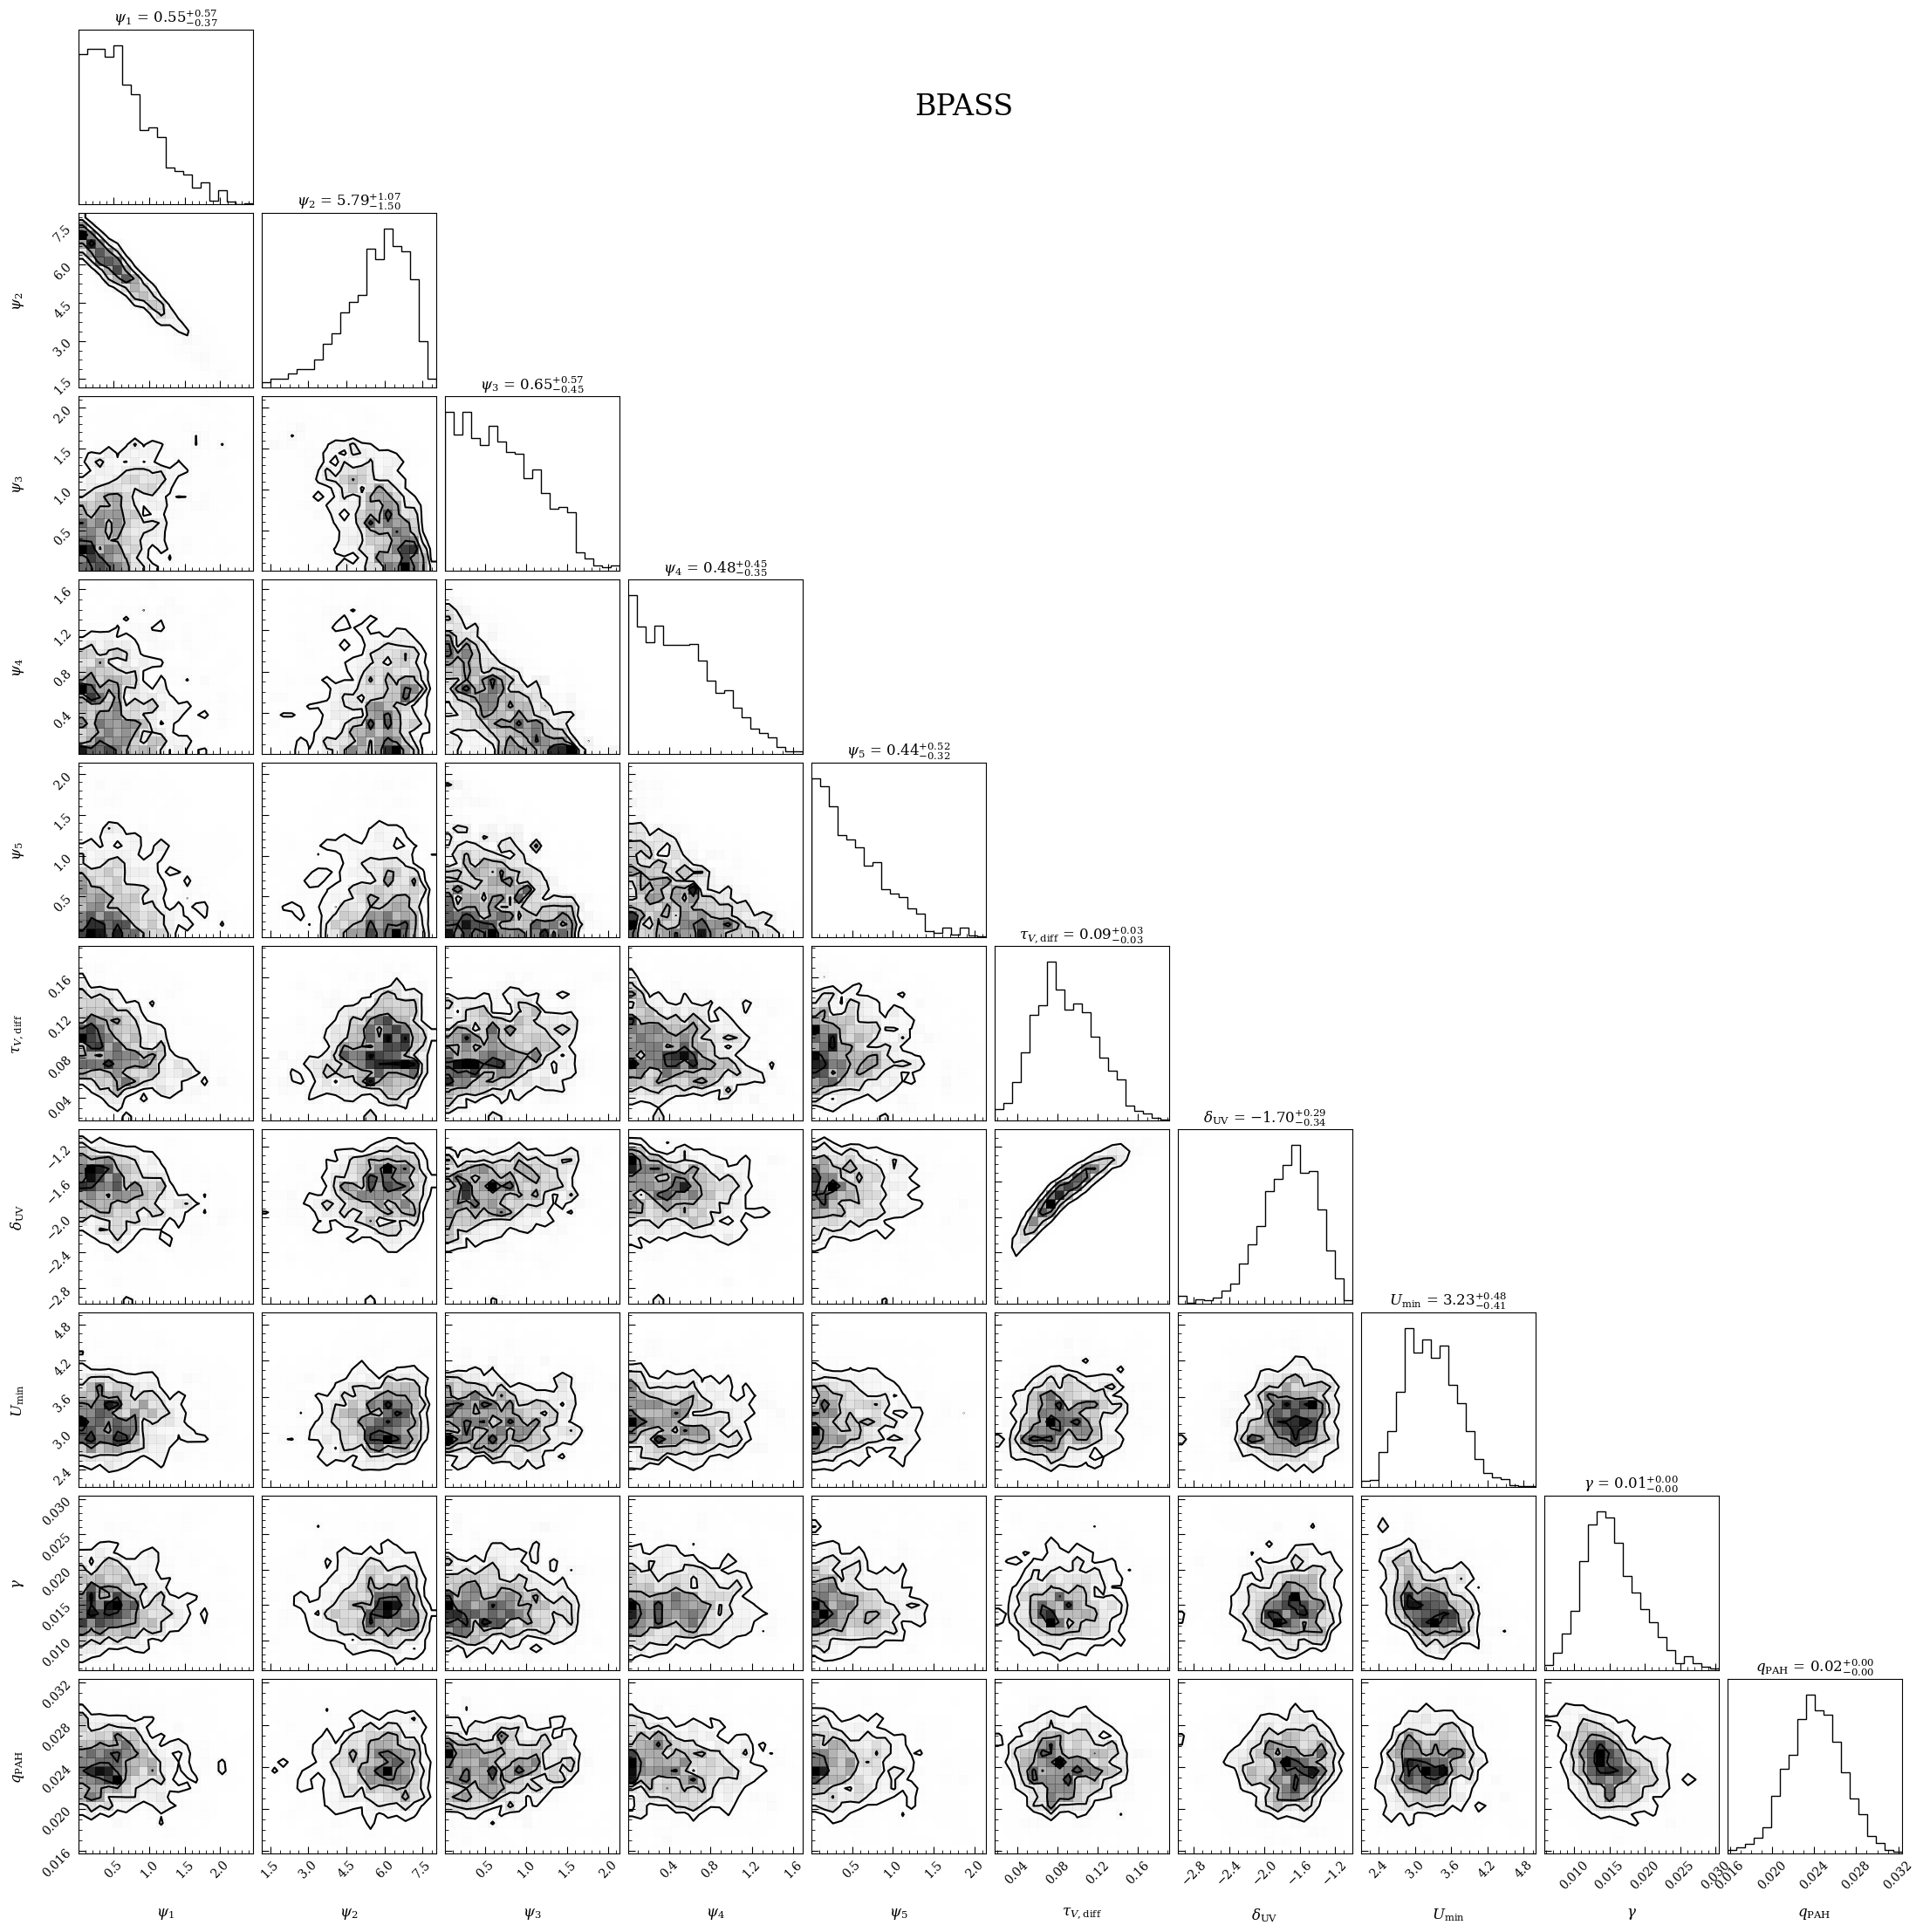

In [8]:
fig_pg = lgh_pg.corner_plot(chain_pg, smooth=0.5, show_titles=True, q=(0.16, 0.50, 0.84))
fig_bp = lgh_bp.corner_plot(chain_bp, smooth=0.5, show_titles=True, q=(0.16, 0.50, 0.84))

fig_pg.text(0.5, 0.95, 'PEGASE', fontsize=24, ha='center', va='top')
fig_bp.text(0.5, 0.95, 'BPASS', fontsize=24, ha='center', va='top')

We can start to see that the BPASS SFR in the third SFH bin is significantly lower. The optical depth $\tau_V$ is smaller by a factor of 2 for the fit with the BPASS models, and they require a larger $\delta$ deviation from the Calzetti UV slope. For reference, nearby galaxies tend to have $\delta \in (-1.4, 0.4)$, from what I remember.

## SED + SFH Plots

We'll overplot both best-fit models with the photometry, plot the SFHs together, and show the residuals in
separate panels.

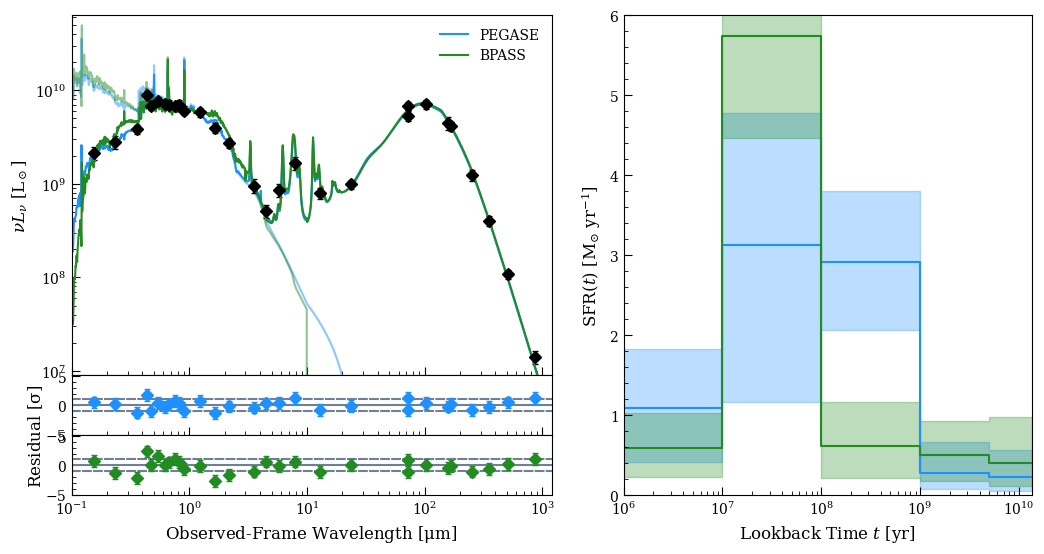

In [26]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.3, 0.4, 0.6])
ax2 = fig.add_axes([0.1, 0.2, 0.4, 0.1])
ax3 = fig.add_axes([0.1, 0.1, 0.4, 0.1])
ax4 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

# fig4, ax41 = sed_plot_bestfit(l, param_arr, logprob_chain,
#                               plot_components=True,
#                               ax=ax41,
#                               legend_kwargs={'loc': 'lower left', 'frameon': False})
# ax41.set_xticklabels([])
# fig4, ax42 = sed_plot_delchi(l, param_arr, logprob_chain, ax=ax42)
# fig4, ax43 = sfh_plot(l, param_arr, ax=ax43)

fig, ax1 = lgh_pg.sed_plot_bestfit(chain_pg, logprob_chain_pg,
                                   plot_components=True,
                                   plot_unatt=True,
                                   ax=ax1,
                                   total_kwargs={'color':'dodgerblue', 'label': None},
                                   stellar_unatt_kwargs={'color':'dodgerblue', 'label':None, 'alpha':0.5},
                                   stellar_att_kwargs={'color':'none', 'label':'Attenuated stellar pop.'},
                                   dust_kwargs={'color':'none', 'label':'Dust'},
                                   data_kwargs={'marker':'D', 'color':'k', 'markerfacecolor':'k', 'capsize':2, 'linestyle':'', 'label': 'Data'},
                                   show_legend=False)
fig, ax1 = lgh_bp.sed_plot_bestfit(chain_bp, logprob_chain_bp,
                                   plot_components=True,
                                   plot_unatt=True,
                                   ax=ax1,
                                   stellar_unatt_kwargs={'color':'forestgreen', 'label':None, 'alpha':0.5},
                                   stellar_att_kwargs={'color':'none', 'label':'Attenuated stellar pop.'},
                                   dust_kwargs={'color':'none', 'label':'Dust'},
                                   total_kwargs={'color':'forestgreen', 'label': None},
                                   data_kwargs={'marker':'', 'color':'none', 'markerfacecolor':'none', 'capsize':0, 'linestyle':'', 'label': 'Data'},
                                   show_legend=False)

ax1.set_xticklabels([])
fig, ax2 = lgh_pg.sed_plot_delchi(chain_pg, logprob_chain_pg, ax=ax2,
                                  data_kwargs={'marker':'D', 'color':'dodgerblue', 'markerfacecolor':'dodgerblue', 'capsize':2, 'linestyle':'', 'label': 'Data'})
fig, ax3 = lgh_bp.sed_plot_delchi(chain_bp, logprob_chain_bp, ax=ax3,
                                  data_kwargs={'marker':'D', 'color':'forestgreen', 'markerfacecolor':'forestgreen', 'capsize':2, 'linestyle':'', 'label': 'Data'})
ax2.set_xticklabels([])
ax2.set_ylabel('')
ax3.set_ylabel('')
fig.text(0.07, 0.2, r'Residual [$\rm \sigma$]', rotation=90, ha='center', va='center')

fig, ax4 = lgh_pg.sfh_plot(chain_pg, ax=ax4,
                           shade_kwargs={'color':'dodgerblue', 'alpha':0.3, 'zorder':0},
                           line_kwargs={'color':'dodgerblue', 'zorder':1})

fig, ax4 = lgh_bp.sfh_plot(chain_bp, ax=ax4,
                           shade_kwargs={'color':'forestgreen', 'alpha':0.3, 'zorder':0},
                           line_kwargs={'color':'forestgreen', 'zorder':1})
ax4.set_ylim(0,6)

from matplotlib.lines import Line2D
lines = [Line2D([],[], color='dodgerblue', label='PEGASE'),
         Line2D([],[], color='forestgreen', label='BPASS')]
ax1.legend(handles=lines)

The fit from $10~\rm \mu m$ is practically identical, and we've seen that the dust parameters are the same, so we can zoom in on the region from $0.1 - 10~\rm \mu m$:

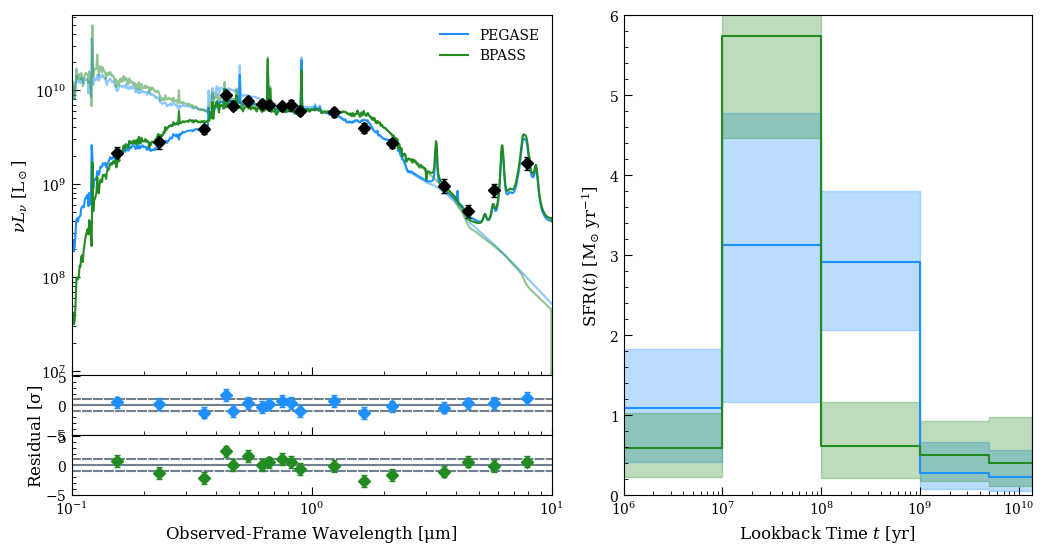

In [27]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.3, 0.4, 0.6])
ax2 = fig.add_axes([0.1, 0.2, 0.4, 0.1])
ax3 = fig.add_axes([0.1, 0.1, 0.4, 0.1])
ax4 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

# fig4, ax41 = sed_plot_bestfit(l, param_arr, logprob_chain,
#                               plot_components=True,
#                               ax=ax41,
#                               legend_kwargs={'loc': 'lower left', 'frameon': False})
# ax41.set_xticklabels([])
# fig4, ax42 = sed_plot_delchi(l, param_arr, logprob_chain, ax=ax42)
# fig4, ax43 = sfh_plot(l, param_arr, ax=ax43)

fig, ax1 = lgh_pg.sed_plot_bestfit(chain_pg, logprob_chain_pg,
                                   plot_components=True,
                                   plot_unatt=True,
                                   ax=ax1,
                                   total_kwargs={'color':'dodgerblue', 'label': None},
                                   stellar_unatt_kwargs={'color':'dodgerblue', 'label':None, 'alpha':0.5},
                                   stellar_att_kwargs={'color':'none', 'label':'Attenuated stellar pop.'},
                                   dust_kwargs={'color':'none', 'label':'Dust'},
                                   data_kwargs={'marker':'D', 'color':'k', 'markerfacecolor':'k', 'capsize':2, 'linestyle':'', 'label': 'Data'},
                                   show_legend=False)
fig, ax1 = lgh_bp.sed_plot_bestfit(chain_bp, logprob_chain_bp,
                                   plot_components=True,
                                   plot_unatt=True,
                                   ax=ax1,
                                   stellar_unatt_kwargs={'color':'forestgreen', 'label':None, 'alpha':0.5},
                                   stellar_att_kwargs={'color':'none', 'label':'Attenuated stellar pop.'},
                                   dust_kwargs={'color':'none', 'label':'Dust'},
                                   total_kwargs={'color':'forestgreen', 'label': None},
                                   data_kwargs={'marker':'', 'color':'none', 'markerfacecolor':'none', 'capsize':0, 'linestyle':'', 'label': 'Data'},
                                   show_legend=False)
                              
ax1.set_xticklabels([])
fig, ax2 = lgh_pg.sed_plot_delchi(chain_pg, logprob_chain_pg, ax=ax2,
                                  data_kwargs={'marker':'D', 'color':'dodgerblue', 'markerfacecolor':'dodgerblue', 'capsize':2, 'linestyle':'', 'label': 'Data'})
fig, ax3 = lgh_bp.sed_plot_delchi(chain_bp, logprob_chain_bp, ax=ax3,
                                  data_kwargs={'marker':'D', 'color':'forestgreen', 'markerfacecolor':'forestgreen', 'capsize':2, 'linestyle':'', 'label': 'Data'})
ax2.set_xticklabels([])
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.set_xlim(0.1, 10)
ax2.set_xlim(0.1, 10)
ax3.set_xlim(0.1, 10)

fig.text(0.07, 0.2, r'Residual [$\rm \sigma$]', rotation=90, ha='center', va='center')

fig, ax4 = lgh_pg.sfh_plot(chain_pg, ax=ax4,
                           shade_kwargs={'color':'dodgerblue', 'alpha':0.3, 'zorder':0},
                           line_kwargs={'color':'dodgerblue', 'zorder':1})

fig, ax4 = lgh_bp.sfh_plot(chain_bp, ax=ax4,
                           shade_kwargs={'color':'forestgreen', 'alpha':0.3, 'zorder':0},
                           line_kwargs={'color':'forestgreen', 'zorder':1})
ax4.set_ylim(0,6)

from matplotlib.lines import Line2D
lines = [Line2D([],[], color='dodgerblue', label='PEGASE'),
         Line2D([],[], color='forestgreen', label='BPASS')]
ax1.legend(handles=lines)

BPASS is giving us a worse fit in the optical due to ... something. Something related to differences in the SEDs in the second or third bins.

## How are the Stellar Populations Different?

A lot of the difference we're seeing seems to be driven by the second or third bin.

/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_5231/279046970.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = lgh_bp.stars.Lnu_obs[i,2,:].flatten() / lgh_pg.stars.Lnu_obs[i,:].flatten()


(0.0, 1.0, 0.0, 1.0)

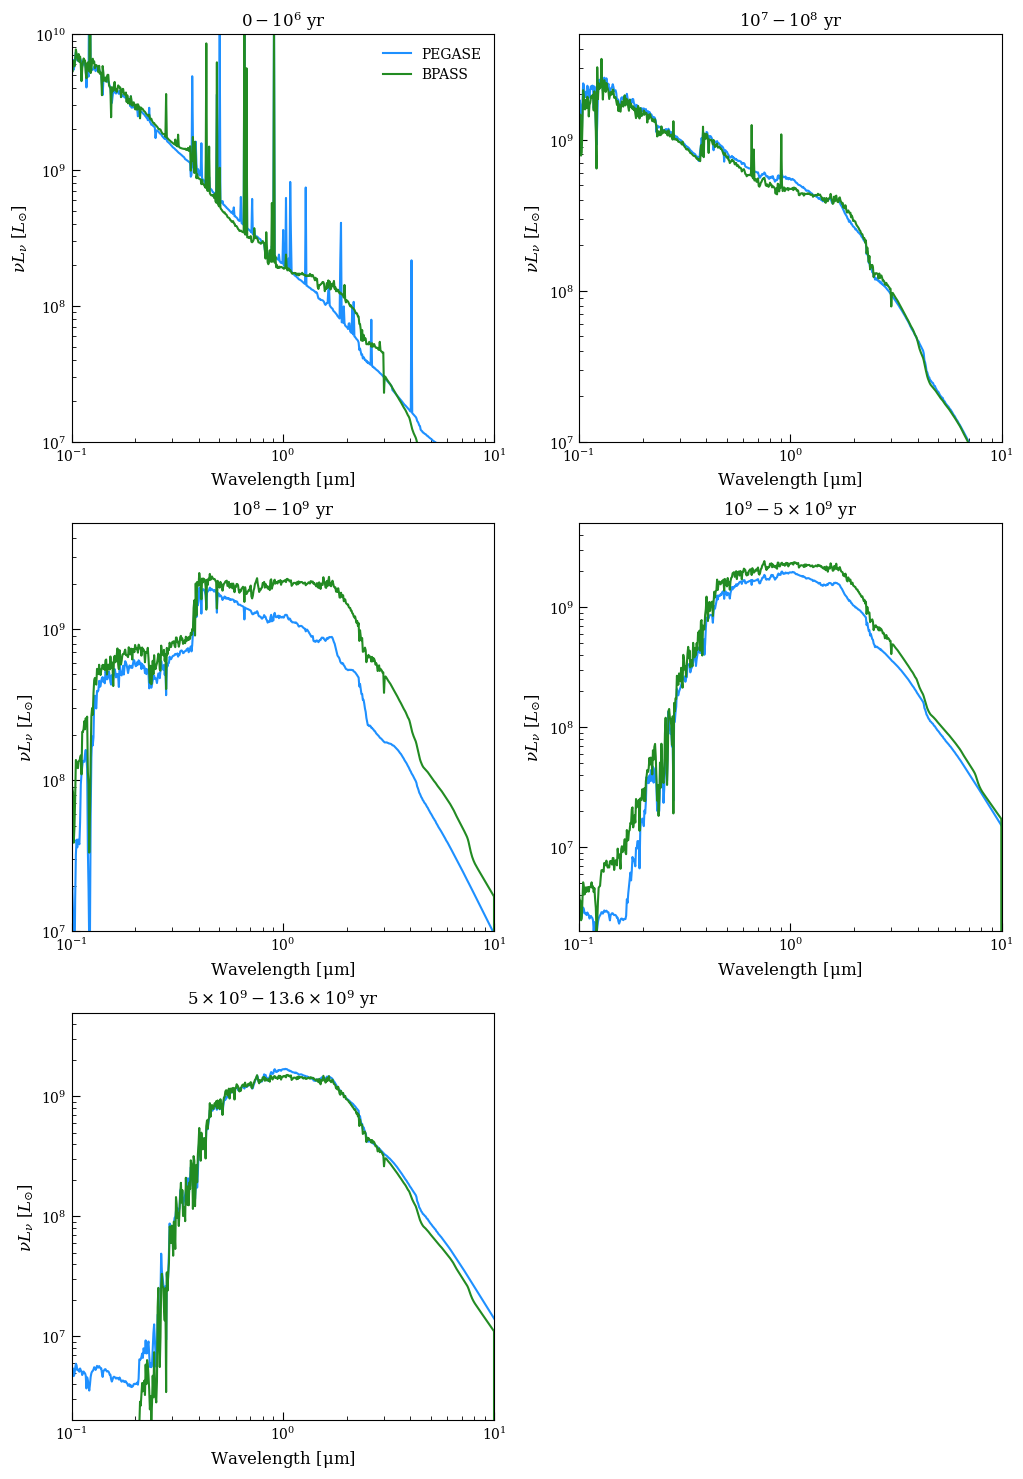

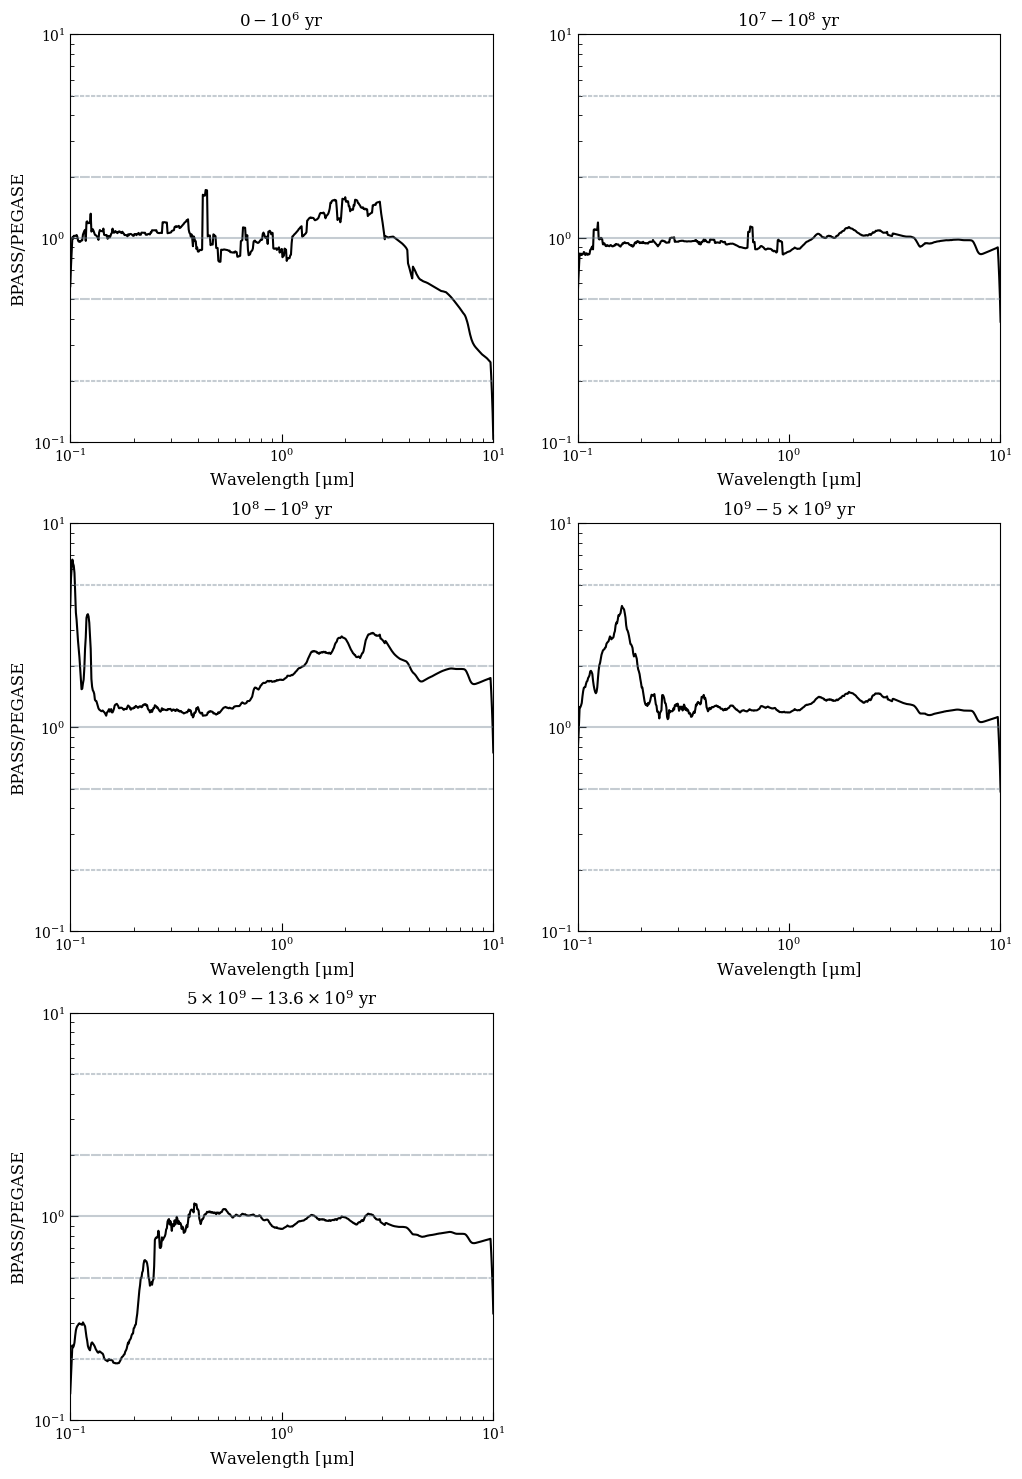

In [20]:
fig,axs = plt.subplots(3,2, figsize=(12,18))
fig2, axs2 = plt.subplots(3,2, figsize=(12,18))

axs = axs.ravel()
axs2 = axs2.ravel()

titles = [r'$0-10^6$ yr', r'$10^7-10^8$ yr', r'$10^8-10^9$ yr', r'$10^9-5 \times 10^9$ yr', r'$5 \times 10^9-13.6 \times 10^9$ yr']

# Smooth the ratio to highlight continuum differences
from astropy.convolution import convolve, Box1DKernel
sm = Box1DKernel(7)

for i in np.arange(5):

    axs[i].plot(lgh_pg.stars.wave_grid_obs, lgh_pg.stars.nu_grid_obs * lgh_pg.stars.Lnu_obs[i,:].flatten(),
        color='dodgerblue', label='PEGASE')
    axs[i].plot(lgh_bp.stars.wave_grid_obs, lgh_bp.stars.nu_grid_obs * lgh_bp.stars.Lnu_obs[i,2,:].flatten(),
        color='forestgreen', label='BPASS')

    ratio = lgh_bp.stars.Lnu_obs[i,2,:].flatten() / lgh_pg.stars.Lnu_obs[i,:].flatten()
    
    axs2[i].plot(lgh_pg.stars.wave_grid_obs, convolve(ratio, sm),
                 color='k')
    axs2[i].axhline(1, color='slategray', alpha=0.4)
    axs2[i].axhline(0.5,linestyle='--', color='slategray', alpha=0.4)
    axs2[i].axhline(2,linestyle='--', color='slategray', alpha=0.4)
    axs2[i].axhline(0.2,linestyle=':', color='slategray', alpha=0.4)
    axs2[i].axhline(5,linestyle=':', color='slategray', alpha=0.4)

    axs[i].set_xscale('log')
    axs[i].set_xlim(0.1, 10)
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e7, 5e9)
    axs[i].set_xlabel(r'Wavelength [$\rm \mu m$]')
    axs[i].set_ylabel(r'$\nu L_{\nu}~[L_{\odot}]$')
    axs[i].set_title(titles[i])

    axs2[i].set_xscale('log')
    axs2[i].set_xlim(0.1, 10)
    axs2[i].set_yscale('log')
    axs2[i].set_ylim(0.1, 10)
    axs2[i].set_xlabel(r'Wavelength [$\rm \mu m$]')
    if i % 2 == 0: axs2[i].set_ylabel(r'BPASS/PEGASE')
    axs2[i].set_title(titles[i])

    if i == 0: axs[i].legend()

axs[-1].axis('off')
axs[0].set_ylim(1e7, 1e10)
axs[-2].set_ylim(2e6, 5e9)
axs[-3].set_ylim(2e6, 5e9)


axs2[-1].axis('off')

# fig.savefig('/Users/eqm5663/Desktop/all_age_bpass_comparison.pdf')
# fig2.savefig('/Users/eqm5663/Desktop/all_age_bpass_ratio.pdf')


What's up with that? There is a difference in the IMF, where the BPASS IMF is extrapolated out to $300~{\rm M_{\odot}}$. In this range of stellar age there's no nebular emission to speak of. The $10^8-10^9$ year bin is the only one that shows such a pronounced difference in the red part of the spectrum; there's a little bit of a red excess in the $10^9- 5 \times 10^9$ year bin, but not rising above a factor of 2. The oldest bin has some differences in the blue part of the spectrum, but the total SED usually has pretty small contributions from the the old population in the UV.